# Layout Study

Exploring the results of the project so far, experimenting creatively.

- regarder les tailles des pages
- faire des categories si on en voit qui se distinguent
- faire un heatmap en fonction
- de tous -> entre chaque journal

In [242]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Taille des Pages

In [4]:
with open("./data/illu_pos.json") as f:
    data = json.load(f)

In [10]:
aspect_ratios = dict()
for k, v in data.items():
    aspect_ratios[k] = v["im_w"]/v["im_h"]

<AxesSubplot:ylabel='Count'>

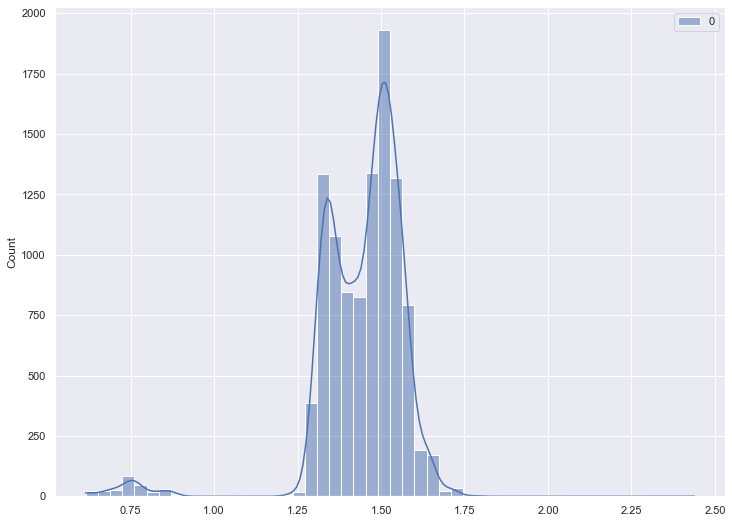

In [24]:
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('darkgrid')
sns.histplot(aspect_ratios.values(), bins=50, kde=True)

In [39]:
aspcrat = pd.DataFrame.from_dict(aspect_ratios, orient='index').rename(columns={0 : "aspect ratio"})

In [42]:
aspcrat[aspcrat["aspect ratio"] < 1].sort_values(by=["aspect ratio"])

,aspect ratio
ILLU_15334_329_0,0.615432
ILLU_15358_223_7,0.615861
ILLU_15358_223_11,0.615861
ILLU_15358_223_10,0.615861
ILLU_15358_223_9,0.615861
...,...
ILLU_10456_79_0,0.872314
ILLU_10725_396_0,0.880512
ILLU_10332_140_0,0.883882
ILLU_10332_144_0,0.883882


In [70]:
median = aspcrat[aspcrat["aspect ratio"] < 1].median(axis=0)
median_2p = median["aspect ratio"]

In [106]:
median_1p = aspcrat[aspcrat["aspect ratio"] > 1].median(axis=0)
median_1p = median_1p["aspect ratio"]

## Heatmap

### On two pages layouts

In [57]:
two_p = list(aspcrat[aspcrat["aspect ratio"] < 1].index)
two_p = { k: data[k] for k in two_p }

In [71]:
median_2p

0.7540993653789224

In [100]:
d = np.zeros((1000, int(median_2p*1000)))
for page in two_p.values():
    for x in range(int(page["x_1"] * 1000), int(page["x_2"] * 1000)):
        for y in range(int(page["y_2"] * int(median_2p*1000)), int(page["y_1"] * int(median_2p*1000))):
            d[x][y] += 1

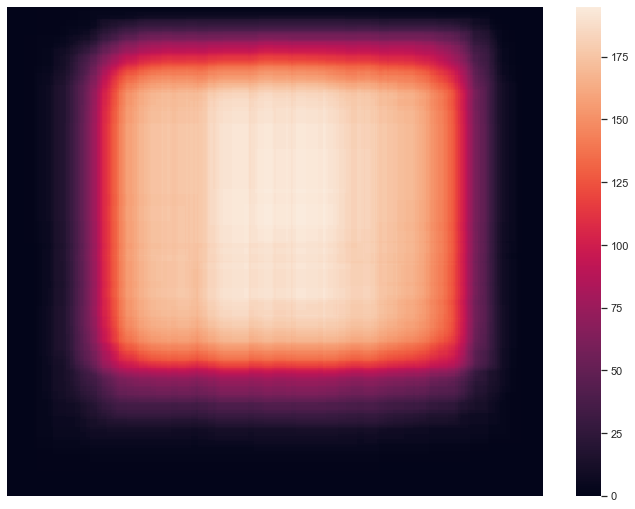

In [102]:
ax = sns.heatmap(d, xticklabels=False, yticklabels=False)

In [160]:
def heatmap_data(dict_data, height, width):
    d = np.zeros((height, width))
    for page in dict_data.values():
        for x in range(int(page["x_1"] * height), int(page["x_2"] * height)):
            for y in range(int(page["y_2"] * width), int(page["y_1"] * width)):
                d[x][y] += 1
    return d

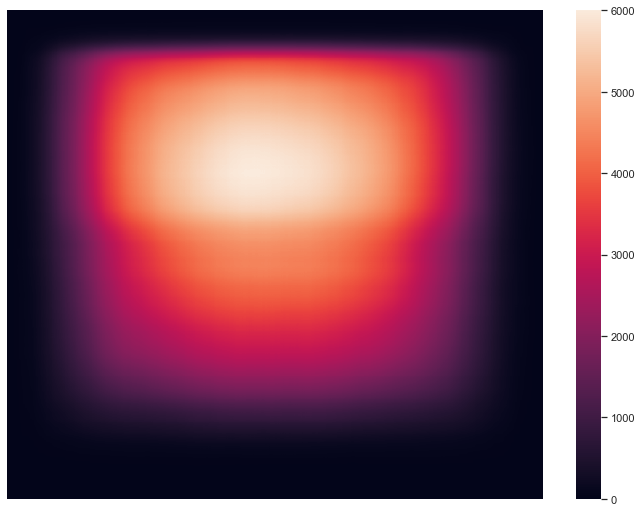

In [127]:
one_p = list(aspcrat[aspcrat["aspect ratio"] > 1].index)
one_p = { k: data[k] for k in one_p }
ax = sns.heatmap(heatmap_data(one_p, 500, int(median_1p*500)), xticklabels=False, yticklabels=False)

### Per journal

In [116]:
# Load the journal info
df = pd.read_csv("./data/DFKV_Master.csv")

In [272]:
j_ids = list(df.groupby("_journal-id").count()["ID"].sort_values(ascending=False).index)
j_ids = [int(j) for j in j_ids]
j_illu_ids = []
for j in j_ids:
    one_j_ids = list(df[df["_journal-id"] == j]["ID"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    if len(aspcrat.loc[one_j.keys()]) > 0 :
        j_illu_ids.append(j)

In [288]:
one_j_ids = list(df[df["_journal-id"] == 1514]["ID"])
one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
aspcrat.loc[one_j.keys()]

,aspect ratio
ILLU_15649_0_0,1.315099
ILLU_15649_0_1,1.315099
ILLU_14754_2_0,1.379323
ILLU_14754_2_1,1.379323
ILLU_15648_1_0,1.300757


In [237]:
# Load the journal info
df2 = pd.read_csv("./data/data.csv")
df2

,id,_description,_artist,_source,_material,_dimensions,_journal-id,_date-artwork,year,keywords,_link-dfkv,_iiif-link,_journal-name,_link-dfkv-md,_link-iiif-md
0,ILLU_10332_143_0,Girl and Cat,Auguste Renoir,NaN,oil on canvas,NaN,1438,1882.0,1910,"Reproduction, Large Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kk191...,Kunst und Künstler,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
1,ILLU_10346_257_0,The death of Laras,Eugène Delacroix,NaN,oil on canvas,62.00x50.00cm,1438,1858.0,1912,"Reproduction, Large Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kk191...,Kunst und Künstler,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
2,ILLU_10359_147_0,Une Baignade à Asnières,Georges Seurat,https://www.nationalgallery.org.uk/paintings/g...,oil on canvas,201.00x300.00cm,1368,1884.0,1932,"Reproduction, Medium Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
3,ILLU_10362_309_0,Landscape,André Derain,NaN,oil on canvas,60.00x73.00cm,1368,1930.0,1932,"Reproduction, Large Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
4,ILLU_10365_17_0,Figure at the Rideau Releve,Henri Matisse,NaN,oil on canvas,NaN,1368,1923.0,1929,"Reproduction, Large Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10369,ILLU_10558_110_0,NaN,NaN,NaN,NaN,NaN,1368,NaN,1910,"Reproduction, Medium Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/kfa19...,Die Kunst für Alle,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10370,ILLU_10575_169129_0,NaN,NaN,NaN,NaN,NaN,1569,NaN,1896,"Reproduction, Medium Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/pan18...,Pan,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10371,ILLU_11353_257_3,NaN,NaN,NaN,NaN,NaN,1336,NaN,1925,"Reproduction, Medium Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://digi.ub.uni-heidelberg.de/diglit/cicer...,Der Cicerone,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://digi.ub.uni-heidelberg.de/digli...
10372,ILLU_14941_159_0,NaN,NaN,NaN,NaN,NaN,1484,NaN,1927,"Reproduction, Medium Illustration",https://dfkv.dfkg.org/ng/index.html#/records/1...,https://gallica.bnf.fr/ark:/12148/bpt6k3054836...,L'Art vivant,[HERE](https://dfkv.dfkg.org/ng/index.html#/re...,[HERE](https://gallica.bnf.fr/ark:/12148/bpt6k...


In [294]:
journals_map_ids = dict()
j_illu_n_ids = []
for j in j_illu_ids:
    try:
        journals_map_ids[j] = df2[df2["_journal-id"]==j].iloc[0]["_journal-name"]
        j_illu_n_ids.append(j)
    except:
        pass

In [298]:
def journal_heatmap(j):
    one_j_ids = list(df[df["_journal-id"] == j]["ID"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    median = aspcrat.loc[one_j.keys()].median(axis=0)["aspect ratio"]
    ax = sns.heatmap(heatmap_data(one_j, 100, int(median*100)), xticklabels=False, yticklabels=False)
    ax.set_title(journals_map_ids[j])
    plt.show()

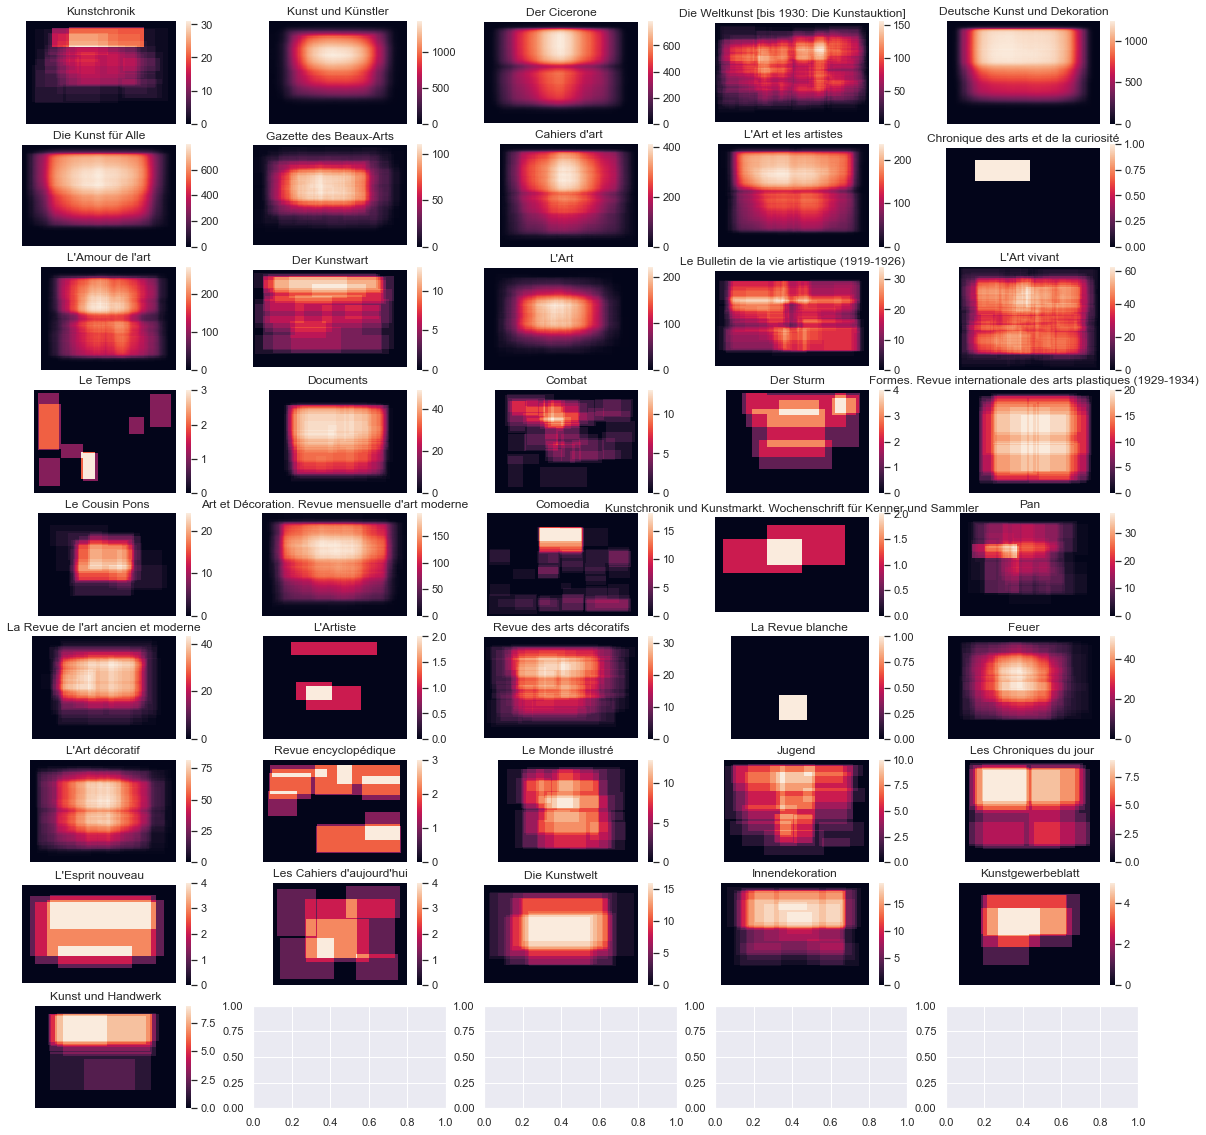

In [318]:
fig, axs = plt.subplots(int(len(j_illu_n_ids)/5) + 1, 5, sharex=False, sharey=False, figsize=(20,20))
for journal, ax in zip(j_illu_n_ids, axs.flatten()):
    one_j_ids = list(df[df["_journal-id"] == journal]["ID"])
    one_j = {k: data[k] for k in data.keys() if int(k.split("_")[1]) in one_j_ids}
    median = aspcrat.loc[one_j.keys()].median(axis=0)["aspect ratio"]
    sns.heatmap(heatmap_data(one_j, 100, int(median*100)), xticklabels=False, yticklabels=False, square=True, ax=ax)
    ax.set_title(journals_map_ids[journal])